In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
# MNISTデータセットの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# モデルの定義
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.layer4 = torch.nn.Flatten()

        self.lstm = nn.LSTM(input_size=64, hidden_size=256, num_layers=3, batch_first=True)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.view(out.size(0), -1, 64)
        lstm_out, _ = self.lstm(out)
        lstm_out = lstm_out[:, -1, :]

        out = self.fc1(lstm_out)
        out = self.fc2(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
 #モデルの学習
def train_model():
    model.train()
    for epoch in range(5):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 順伝播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 逆伝播と最適化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/5], Loss: {running_loss / len(train_loader):.4f}")

    # モデルを保存
    torch.save(model.state_dict(), "cnn_lstm_mnist.pth")
    print("Model saved as cnn_lstm_mnist.pth")


In [ ]:
# テストデータでの評価
def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# 学習と評価の実行
train_model()
evaluate_model()

Epoch [1/5], Loss: 0.2530
Epoch [2/5], Loss: 0.0778
Epoch [3/5], Loss: 0.0550
Epoch [4/5], Loss: 0.0451
Epoch [5/5], Loss: 0.0370
Model saved as cnn_lstm_mnist.pth
Accuracy: 98.83%


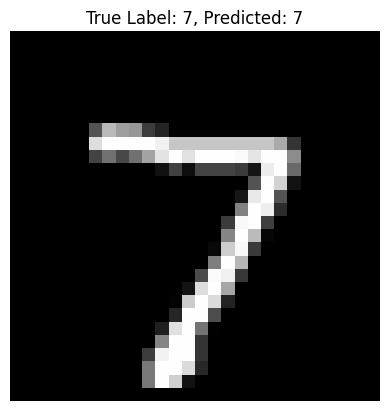

In [ ]:
# 推論の実行と画像表示
def predict_and_display():
    model.eval()
    sample, label = test_dataset[0]
    sample = sample.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(sample)
        _, predicted = torch.max(output.data, 1)

    # 画像の表示
    plt.imshow(sample.cpu().squeeze().numpy(), cmap="gray")
    plt.title(f"True Label: {label}, Predicted: {predicted.item()}")
    plt.axis("off")
    plt.show()

predict_and_display()

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import random

In [ ]:
# モデルクラスの定義
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        self.layer4 = torch.nn.Flatten()

        self.lstm = nn.LSTM(input_size=64, hidden_size=256, num_layers=3, batch_first=True)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.view(out.size(0), -1, 64)
        lstm_out, _ = self.lstm(out)
        lstm_out = lstm_out[:, -1, :]

        out = self.fc1(lstm_out)
        out = self.fc2(out)
        return out


In [ ]:
# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルの初期化とロード
model = CNN_LSTM().to(device)
model.load_state_dict(torch.load("cnn_lstm_mnist.pth"))
model.eval()

# MNISTデータセットの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


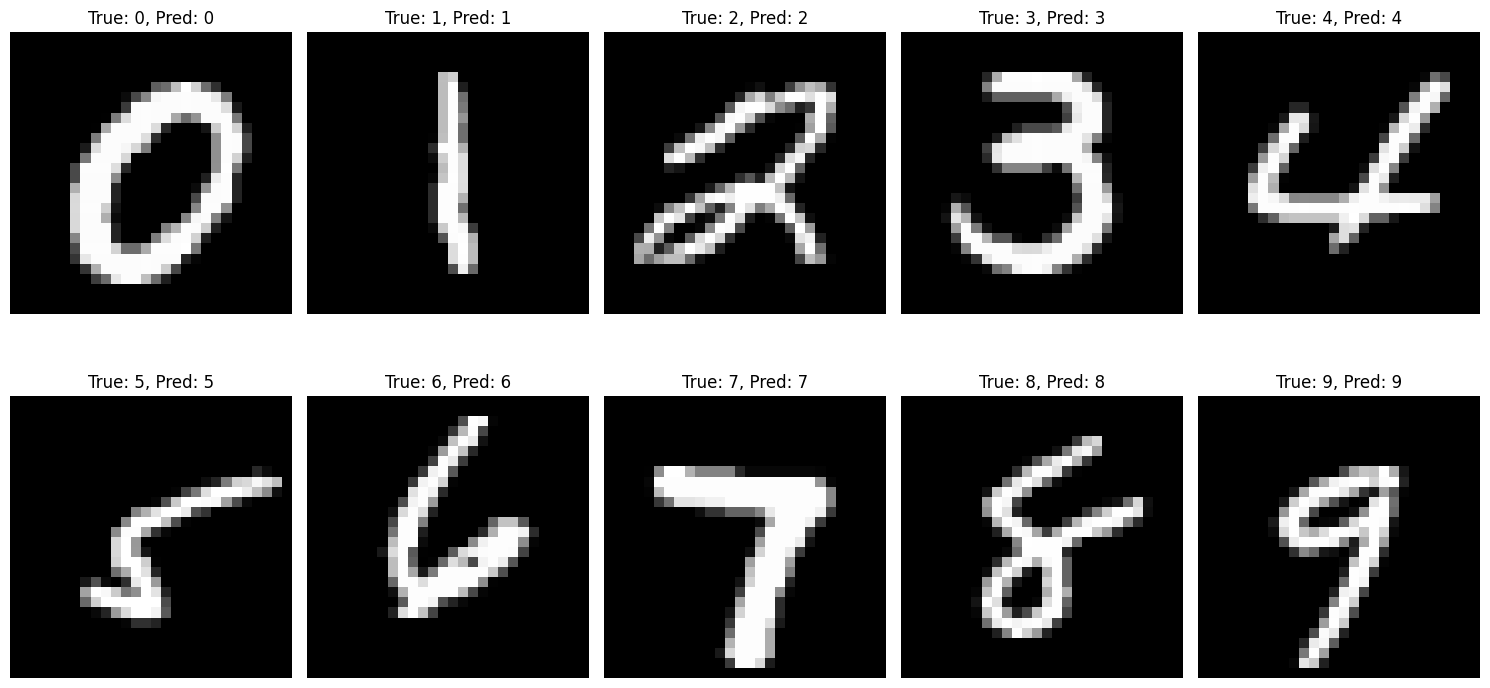

In [ ]:
# 各ラベルごとにランダムな画像を抽選して推論
def display_random_predictions():
    random_indices = {label: random.choice([i for i, (_, l) in enumerate(test_dataset) if l == label]) for label in range(10)}

    plt.figure(figsize=(15, 8))  # 図のサイズを指定

    for label, index in random_indices.items():
        image, true_label = test_dataset[index]
        image_tensor = image.unsqueeze(0).to(device)  # バッチ次元を追加
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output.data, 1)

        # 画像と推論結果をプロット
        plt.subplot(2, 5, label + 1)
        plt.imshow(image.squeeze().numpy(), cmap="gray")
        plt.title(f"True: {true_label}, Pred: {predicted.item()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ランダムな画像で推論を表示
display_random_predictions()